In [1]:
import numpy as np
import pygam
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import itertools
import scipy as sp
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import seaborn as sb
plt.style.use('default')

import sys
sys.path.append("../../scripts")
import visutil

DATA_DIR = "../../data/mESC/"
FIG_DIR = "./"

In [2]:
try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

In [3]:
adata = ad.AnnData(np.load(DATA_DIR+"X.npy"))
adata.obs["dpt"] = np.load(DATA_DIR+"dpt.npy")
adata.var["gene"] = np.load(DATA_DIR+"genes.npy")
adata.var["gene"] = adata.var["gene"].str.capitalize()
adata.varm["J"] = np.load(DATA_DIR+"J.npy")
adata.varm["J_ESCAPE"] = np.load(DATA_DIR+"J_ESCAPE.npy")
adata.obsm["X_pca"] = np.load(DATA_DIR + "X_pca.npy")
adata.obsm["C"] = np.load(DATA_DIR+"C.npy")
# load locaTE outputs
G = np.load("G_locate.npy")
G = np.swapaxes(G.reshape(-1, adata.shape[1], adata.shape[1]), 1, 2).reshape(-1, adata.shape[1]**2) # fix Julia orientation
U = np.load("U.npy").astype(np.float64)
V = np.load("V.npy").astype(np.float64)
V = np.swapaxes(V.reshape(adata.shape[1], adata.shape[1], -1), 0, 1).reshape(adata.shape[1]**2, -1) # fix Julia orientation

# NTF
for i in range(3):
    adata.uns["A_{}".format(i)] = np.load("A_{}.npy".format(i+1)).astype(np.float64)

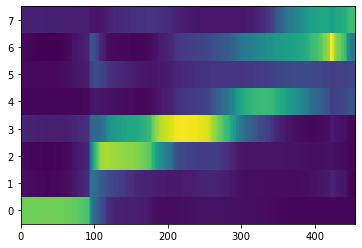

In [4]:
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in U.T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([adata.obs.dpt[np.argmax(x / sum(x))] for x in U_gam.T])
U = U[:, perm]
U_gam = U_gam[:, perm]
V = V[:, perm]
plt.imshow(U_gam[np.argsort(adata.obs.dpt), :].T, interpolation = "none", origin = "lower")
plt.axis("auto")
del perm

Text(331.49999999999994, 0.5, 'Regulatory module')

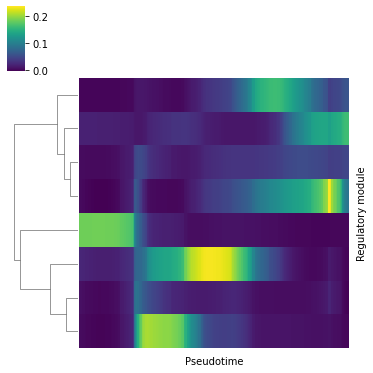

In [5]:
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis")
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Regulatory module")

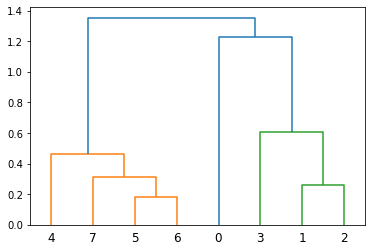

In [6]:
Z = cg.dendrogram_row.calculated_linkage
scipy.cluster.hierarchy.dendrogram(Z);

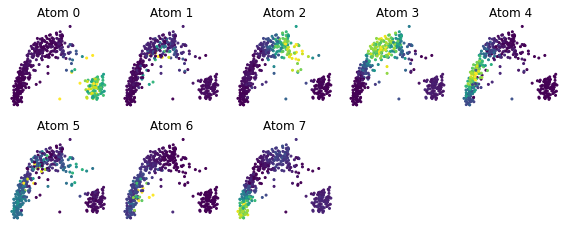

In [7]:
plt.figure(figsize = (8, 8))
for i in range(U.shape[1]):
    plt.subplot(5, 5, i+1)
    plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = U[:, i], s = 4, vmax = np.quantile(U[:, i], 0.99))
    plt.title("Atom {}".format(i))
    plt.axis("off")
plt.tight_layout()

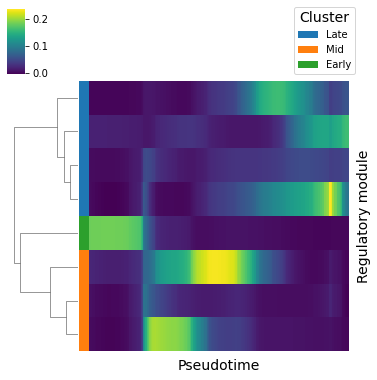

In [8]:
clusterids = fcluster(Z, 3, criterion = 'maxclust')
colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, 3+1)}
clusterdict = {3 : "Early", 1 : "Late", 2 : "Mid"}
colors = [colordict[i] for i in clusterids]

from matplotlib.patches import Patch
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", row_colors = colors, rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Regulatory module", fontsize = 14)

idxs = [1, 2, 3]
handles = [Patch(facecolor=colordict[i]) for i in idxs]
plt.legend(handles, [clusterdict[i] for i in idxs], title='Cluster',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right', title_fontsize = 14)
cg.savefig(FIG_DIR + "hayashi_nmf_coeffs.pdf")

In [9]:
import ot 
import itertools
from tqdm import tqdm
import pandas as pd

C = np.zeros((U.shape[1], U.shape[1]))
for (i, j) in tqdm(itertools.product(range(U.shape[1]), range(U.shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(U[:, i] / U[:, i].sum(), U[:, j] / U[:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]
C /= C.mean()

64it [00:00, 82.71it/s] 


/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


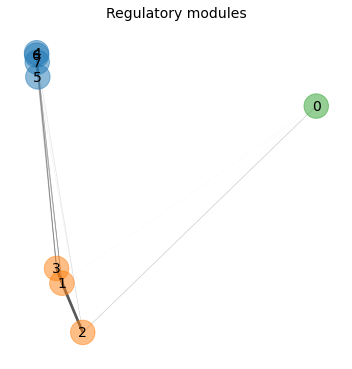

In [10]:
import sklearn as sk
K = np.exp(-C / (np.median(C, axis = -1).reshape(-1, 1)))
K /= K.mean()
t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 0, j) for j in range(K.shape[0])])
g = nx.Graph(K)
nx.set_node_attributes(g, {i : clusterids[i] for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
pos = nx.spectral_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
visutil.draw(g, 
             gene_names = [str(i) for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : matplotlib.colors.ListedColormap([colordict[i] for i in np.unique(clusterids)]), "alpha" : [0.5 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory modules", fontsize = 14)
plt.savefig("NMF_modules.pdf")

In [11]:
stage = np.array([clusterdict[i] for i in clusterids])
g_all = []
for s in ["Early", "Mid", "Late"]:
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    g_all += [g, ]
thresh = 0.9975
g_agg, nodes, pos = visutil.get_union_graph(g_all, adata.var.index, thresh, layout_args = "-Gstart=0")

/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/mESC/../../scripts/visutil.py:69: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_all = [np.array(nx.adjacency_matrix(g).todense()) for g in g_all]


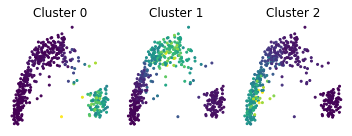

In [12]:
plt.figure(figsize = (5, 2))
for (i, s) in enumerate(["Early", "Mid", "Late"]):
    A = np.mean(U * (stage == s), -1)
    plt.subplot(1, 3, i+1)
    plt.scatter(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 1], c = A, s = 4)
    plt.title("Cluster {}".format(i))
    plt.axis("off")
plt.tight_layout()
plt.savefig("NMF_clusters.pdf")

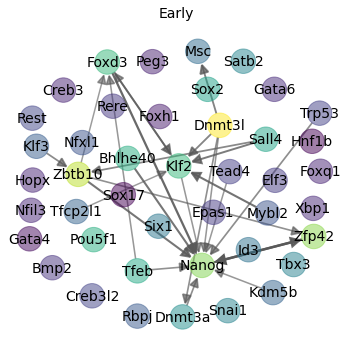

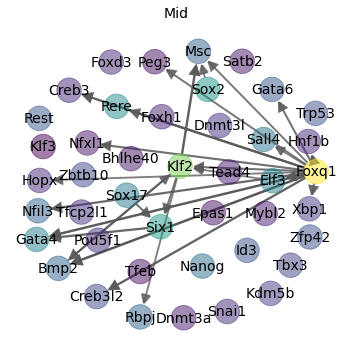

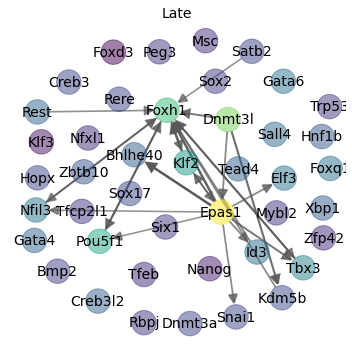

In [13]:
for s in ["Early", "Mid", "Late"]:
    plt.figure(figsize = (5, 5))
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    nx.set_edge_attributes(g, {(i, j) : adata.varm["J"][i, j] for (i, j) in g.edges}, name = "ref")
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    # visutil.draw(g, adata.var['gene'], thresh = 0.9975, layout_args = "-Gstart=1")
    visutil.draw(g, adata.var['gene'], node_list = nodes, pos = pos, thresh = thresh)
    plt.gca().axis("off")
    plt.title(s, fontsize = 14)
    plt.tight_layout()
    plt.savefig(FIG_DIR + "hayashi_nmf_network_%s.pdf" % s)

In [14]:
# top-k out edges
def outedge_counts(A, cutoff = 1_000):
    cutoff = np.sort(A.flatten())[::-1][cutoff]
    A[A <= cutoff] = 0
    return np.sum(A > 0, -1)

def outedge_eigen_centrality(A):
    g = nx.DiGraph(A)
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    nodes, centrality = zip(*nx.get_node_attributes(g,'centrality').items())
    return centrality

for s in ["Early", "Mid", "Late"]:
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    # counts = outedge_counts(A.reshape(adata.shape[1], adata.shape[1]))
    # pd.DataFrame({s : adata.var.gene[np.argsort(counts)[::-1][0:25]]}).to_csv("genelist_nmf_%s.csv" % s, header = True, index = False)
    centrality = outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1]))
    pd.DataFrame({"gene" : adata.var.gene[np.argsort(centrality)[::-1][0:25]]}).to_csv("genelist_nmf_%s.csv" % s, header = True, index = False)

In [15]:
!paste -d, genelist_nmf_Early.csv genelist_nmf_Mid.csv genelist_nmf_Late.csv > genelist_nmf_all.csv

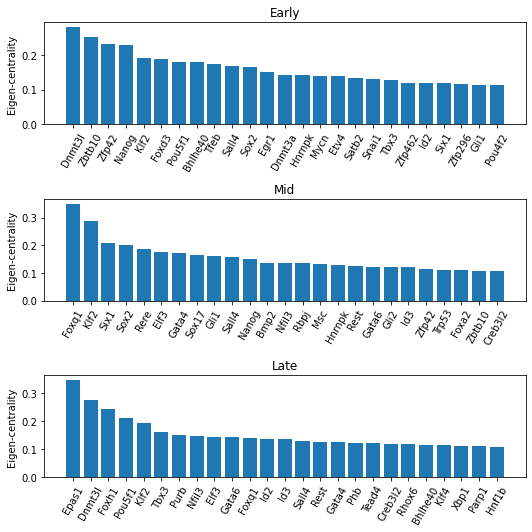

In [20]:
plt.figure(figsize = (7.5, 7.5))
for (i, s) in enumerate(["Early", "Mid", "Late"]):
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    # counts = outedge_counts(A.reshape(adata.shape[1], adata.shape[1]))
    # idx = np.argsort(counts)[::-1][0:25]
    centrality = np.array(outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1])))
    idx = np.argsort(centrality)[::-1][0:25]
    plt.subplot(3, 1, i+1)
    plt.bar(range(len(idx)), centrality[idx])
    plt.xticks(range(len(idx)), adata.var.gene[idx], rotation = 60);
    plt.title(s)
    plt.ylabel("Eigen-centrality")
plt.tight_layout()
plt.savefig(FIG_DIR + "hayashi_nmf_stage_centrality.pdf")

In [21]:
# background genes
pd.DataFrame({"gene" : adata.var.gene}).to_csv("genelist_background.csv", header = True, index = False)

(-19.675415000000005, 515.172415, -29.062780000000004, 508.94678)

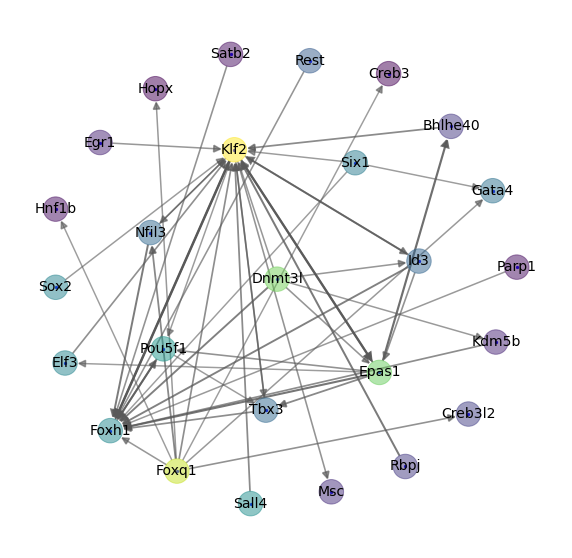

In [26]:
g = nx.DiGraph(np.mean(G[adata.obs.dpt < 0.9, :], axis = 0).reshape(adata.shape[1], adata.shape[1]))

nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
# get weights from g
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
weights = np.array(list(weights))
weights /= np.max(weights)
# node and edgelist
nl = list(g.nodes())
el = list(g.edges())
edge_idx = np.where(weights > np.quantile(weights, 0.995))[0]
edgelist = [el[i] for i in edge_idx]

node_idx = list(set(itertools.chain(*edgelist)))
nodelist = [nl[i] for i in node_idx]
# take subgraph
g_sub = g.subgraph(nodelist)

# now plot
edges,weights = zip(*nx.get_edge_attributes(g_sub,'weight').items())
weights = np.array(list(weights))
weights /= np.quantile(weights, 0.999)
weights = np.minimum(1, weights)
edge_idx2 = np.where([e in edgelist for e in g_sub.edges()])[0]

fig = plt.figure(figsize = (10, 10))
# pos = nx.shell_layout(g_sub)
# pos = nx.spring_layout(g_sub, iterations = 250, seed = 0)
pos = nx.nx_agraph.graphviz_layout(g_sub, prog = 'fdp')
nx.draw_networkx_nodes(g_sub, pos, node_color = "b", node_size = 5)
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = weights[edge_idx2], alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = matplotlib.colormaps["MyGrey"], edge_vmin = 0.1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.gene[i] for i in g_sub.nodes()}, font_size = 14);
nodes, centrality = zip(*nx.get_node_attributes(g_sub,'centrality').items())
centrality /= np.max(centrality)
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.5, node_size = 600)
plt.axis("off")

(-0.5, 455.5, 49.5, -0.5)

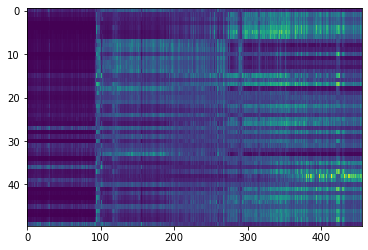

In [27]:
G_tensor = G.reshape(-1, adata.shape[1], adata.shape[1])
G_subset = np.vstack([G_tensor[:, i, j] for (i, j) in edgelist])
plt.imshow(G_subset[:, np.argsort(adata.obs.dpt)], interpolation = "none")
plt.axis("auto")

In [28]:
import seaborn as sb
gams = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, x) for x in G_subset]
G_gam = np.vstack([g.predict(adata.obs.dpt) for g in gams])
# G_gam /= G_gam.sum(-1).reshape(-1, 1)
row_perm = np.argsort(np.mean(G_gam * np.array(adata.obs.dpt).reshape(1, -1), -1))

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


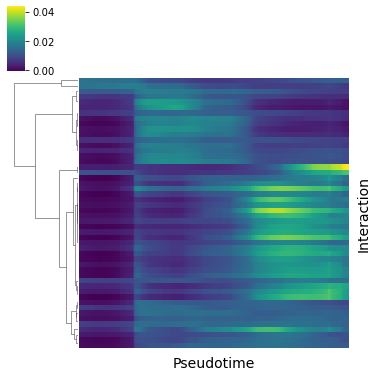

In [29]:
import scipy
cg = sb.clustermap(G_gam[:, np.argsort(adata.obs.dpt)], col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Interaction", fontsize = 14)
cg.savefig(FIG_DIR + "hayashi_interactions_clustermap.pdf")

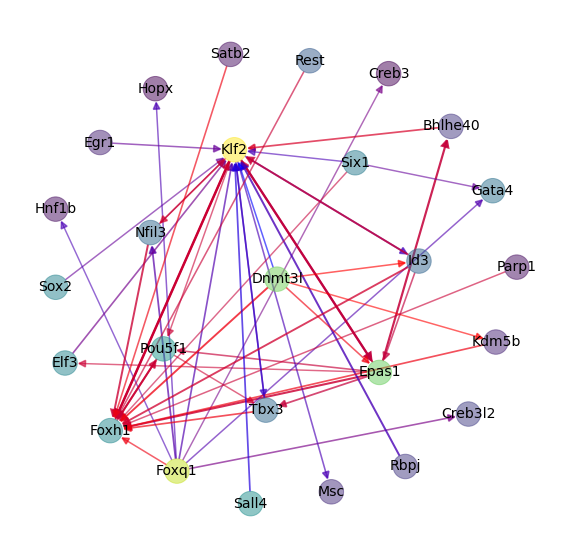

In [30]:
active_dpt = np.array(adata.obs.dpt)[np.argsort(G_gam, -1)[:, -1]]
# fig = plt.figure(figsize = (10, 10))
blue_red1 = matplotlib.colors.LinearSegmentedColormap.from_list("BlueRed1", ['blue', 'red'])
fig = plt.figure(figsize = (10, 10))
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = active_dpt, alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = blue_red1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.gene[i] for i in g_sub.nodes()}, font_size = 14);
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.5, node_size = 600)
plt.axis("off")
plt.savefig(FIG_DIR + "hayashi_interactions_color_network.pdf")

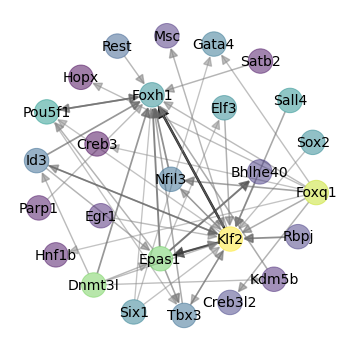

In [31]:
interactions = list(itertools.chain(*[[(adata.var.gene[i], adata.var.gene[j]) for j in range(adata.shape[1])] for i in range(adata.shape[1])]))
true_interactions = set([interactions[i] for i in np.where(adata.varm["J_ESCAPE"].flatten())[0]])
A = np.mean(G[adata.obs.dpt < 0.9, :], 0)
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
fig = plt.figure(figsize = (5, 5))
visutil.draw(g, adata.var.gene, thresh = 0.995, cmap_dict = {0 : "Greys"}, layout_args = "-Gstart=2")
plt.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR + "hayashi_static_network.pdf")

In [129]:
# NTF
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in adata.uns["A_0"].T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([np.dot(adata.obs.dpt, x / sum(x)) for x in U_gam.T])
adata.uns["A_0"] = adata.uns["A_0"][:, perm]
adata.uns["A_1"] = adata.uns["A_1"][:, perm]
adata.uns["A_2"] = adata.uns["A_2"][:, perm]
U_gam = U_gam[:, perm]
del perm

(-0.5, 455.5, -0.5, 31.5)

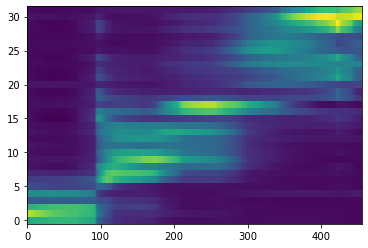

In [130]:
plt.imshow(U_gam[np.argsort(adata.obs.dpt), :].T, interpolation = "none", origin = "lower")
plt.axis("auto")

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(331.49999999999994, 0.5, 'Regulatory module')

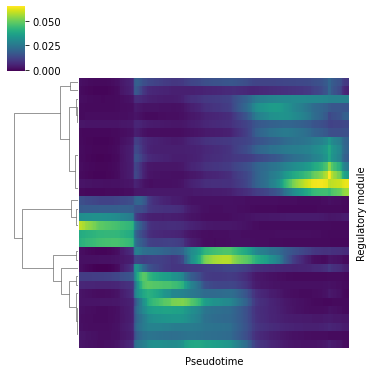

In [131]:
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis")
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Regulatory module")

Text(331.50000000000006, 0.5, 'Regulatory module')

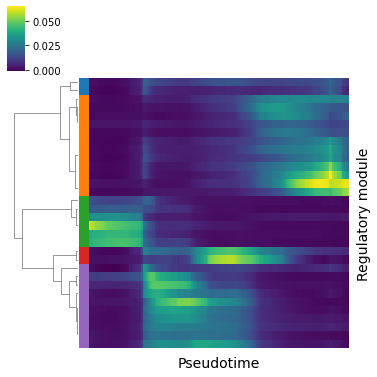

In [132]:
Z = cg.dendrogram_row.calculated_linkage
clusterids = fcluster(Z, 5, criterion = 'maxclust')
colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, len(np.unique(clusterids))+1)}
clusterdict = {k : "cluster_{}".format(k) for k in np.unique(clusterids)}
colors = [colordict[i] for i in clusterids]

from matplotlib.patches import Patch
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", row_colors = colors, rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Regulatory module", fontsize = 14)

In [133]:
C = np.zeros((adata.uns["A_0"].shape[1], adata.uns["A_0"].shape[1]))
for (i, j) in tqdm(itertools.product(range(adata.uns["A_0"].shape[1]), range(adata.uns["A_0"].shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(adata.uns["A_0"][:, i] / adata.uns["A_0"][:, i].sum(), adata.uns["A_0"][:, j] / adata.uns["A_0"][:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]

1024it [00:19, 52.14it/s]


/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Text(0.5, 1.0, 'Regulatory module dynamics')

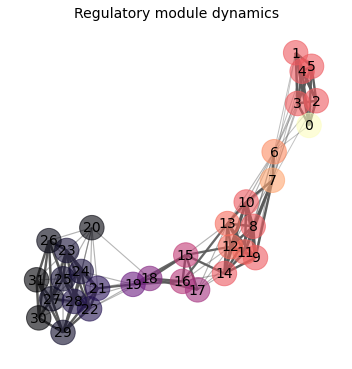

In [134]:
import sklearn as sk
from sklearn import neighbors
A = sk.neighbors.NearestNeighbors(n_neighbors=8, metric = 'precomputed').fit(C).kneighbors_graph(C).toarray()
A = 0.5*(A + A.T)

K = np.exp(-0.25*C / np.median(C, axis = -1).reshape(-1, 1)) * A
K /= K.max()
t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 0, j) for j in range(K.shape[0])])
g = nx.Graph(K)

nx.set_node_attributes(g, {i : np.exp(-t[i] / t.max()) for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
# pos = nx.spectral_layout(g)
pos = nx.spring_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
module_names = {i : str(i) for i in range(K.shape[0])}
visutil.draw(g, 
             gene_names = [str(module_names[i]) if i in module_names.keys() else "" for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : plt.cm.magma, "alpha" : [0.6 if i in module_names.keys() else 0.3 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory module dynamics", fontsize = 14)

In [135]:
g_all = []
for k in range(adata.uns["A_0"].shape[1]):
    A = np.outer(adata.uns["A_1"][:, k].T, adata.uns["A_2"][:, k].T)
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    g_all += [g, ]
thresh = 0.9995
_, nodes, pos = visutil.get_union_graph(g_all, adata.var.index, thresh, layout_args = "-Gstart=1")

/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/mESC/../../scripts/visutil.py:69: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_all = [np.array(nx.adjacency_matrix(g).todense()) for g in g_all]


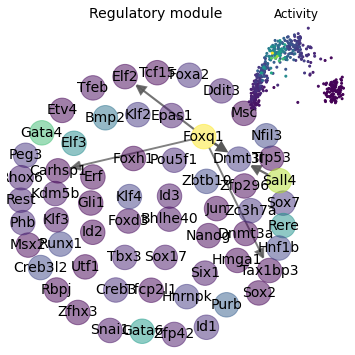

In [155]:
i = 16
A = np.outer(adata.uns["A_1"][:, i].T, adata.uns["A_2"][:, i].T)
g = nx.DiGraph(A)
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (5, 5))
# visutil.draw(g, adata.var.gene, thresh = 0.9975, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
visutil.draw(g, adata.var.gene, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = adata.uns["A_0"][:, i]
axin.scatter(adata.obsm["X_pca"][np.argsort(p), 0], adata.obsm["X_pca"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("Activity")
plt.title("Regulatory module", fontsize = 14)
plt.tight_layout()